<a href="https://colab.research.google.com/github/vijayjoyz/NLP-Model/blob/master/NLPmodel_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NLP Model with TensorFlow

In [0]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


#Dataset 
We download the dataset which is provided by the people in google.

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-03-04 20:10:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 2404:6800:4003:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2020-03-04 20:10:40 (248 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



#Features & Label
From the download json data we take feature and label for training the NLP Classifier Model

Feature -> headline

Label   -> is_sarcastic

In [0]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [0]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

#NLP Steps
By understanding the data we will classify the given data as sarcastic or not!

But to do that the general steps are need to be followed

#Tokenization
This process is the first step where the given words will be converted to different id or word_index.
Example -- I love ML can have a following word_index [0,1,2]
#Padding Sequences
The padding sequence is used to have a padding value to the given sentence to make every sequence of sentence in a same length,since the neural net needs a fixed size of input.

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

#Model Creation

But you might be wondering at this point,we've turned our sentences into numbers,
with the numbers being tokens representing words.
But how do we get meaning from that?
How do we determine if something is sarcastic just
from the numbers?
Well, here's where the context of embeddings come in.

Let's consider the most basic of sentiments.
Something is good or something is bad.
We often see these as being opposites,
so we can plot them as having opposite directions.
So then what happens with a word like "meh"?
It's not particularly good, and it's not particularly bad.
Probably a little more bad than good.
Or the phrase, "not bad," which is usually
meant to plot something as having
a little bit of goodness, but not necessarily very good.




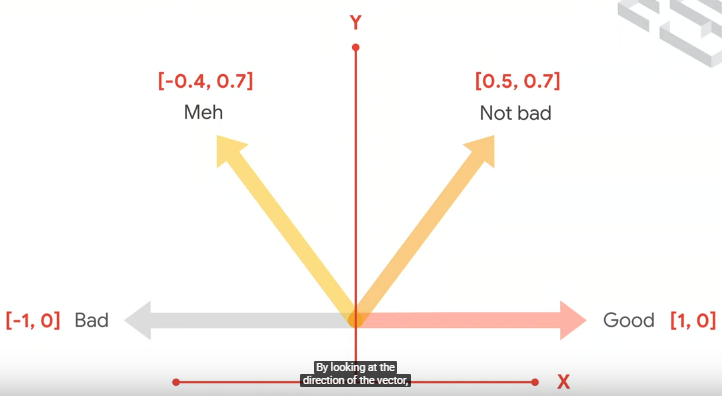

In [14]:
from IPython.display import Image
source = "Screenshot (49).png"
Image(source)


Now, if we plot this on an x- and y-axis as shown in above image,

we can start to determine the good or bad sentiment
as coordinates in the x and y.
Good is 1, 0.
Meh is minus 0.4, 0.7, et cetera.
By looking at the direction of the vector,
we can start to determine the meaning of the word.
So what if you extend that into multiple dimensions instead
of just two?
What if words that are labeled with sentiments,
like sarcastic and not sarcastic,
are plotted in these multiple dimensions?
And then, as we train, we try to learn
what the direction in these multi-dimensional spaces
should look like.
Words that only appear in the sarcastic sentences
will have a strong component in the sarcastic direction,
and others will have one in the not-sarcastic direction.
As we load more and more sentences
into the network for training, these directions can change.
And when we have a fully trained network
and give it a set of words, it could look up
the vectors for these words, sum them up, and thus, give us
an idea for the sentiment.
This concept is known as embedding.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [0]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 6s - loss: 0.6543 - accuracy: 0.6054 - val_loss: 0.5423 - val_accuracy: 0.8061
Epoch 2/30
20000/20000 - 3s - loss: 0.4030 - accuracy: 0.8424 - val_loss: 0.3753 - val_accuracy: 0.8411
Epoch 3/30
20000/20000 - 3s - loss: 0.2964 - accuracy: 0.8821 - val_loss: 0.3494 - val_accuracy: 0.8523
Epoch 4/30
20000/20000 - 3s - loss: 0.2448 - accuracy: 0.9043 - val_loss: 0.3422 - val_accuracy: 0.8550
Epoch 5/30
20000/20000 - 3s - loss: 0.2095 - accuracy: 0.9183 - val_loss: 0.3508 - val_accuracy: 0.8515
Epoch 6/30
20000/20000 - 3s - loss: 0.1827 - accuracy: 0.9313 - val_loss: 0.3938 - val_accuracy: 0.8369
Epoch 7/30
20000/20000 - 4s - loss: 0.1616 - accuracy: 0.9402 - val_loss: 0.3782 - val_accuracy: 0.8517
Epoch 8/30
20000/20000 - 4s - loss: 0.1438 - accuracy: 0.9477 - val_loss: 0.3976 - val_accuracy: 0.8524
Epoch 9/30
20000/20000 - 4s - loss: 0.1298 - accuracy: 0.9544 - val_loss: 0.4198 - val_accuracy: 0.8508
Epoch 10/30
200

#Visualization 
Here we use the graphs to show the relationship between the accuracy and loss of both training and validation data.

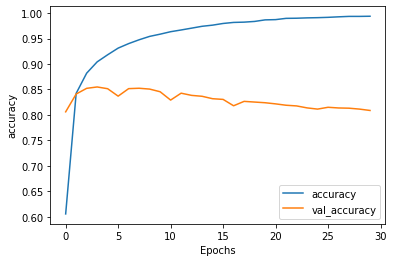

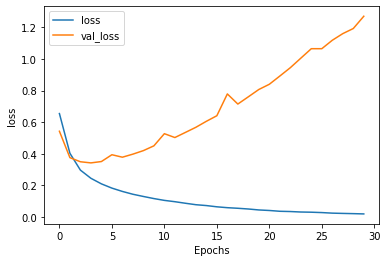

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

#Prediction
Here we specifiy the sentence in sarcastic and opposite way and the prediction gave show the result correctly

In [0]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[8.0650014e-01]
 [2.5326011e-07]]
